## Download Dataset


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
!gdown --id 1tPhPdJ6lHxvACgz2y-GWVRBhr9sBU4dd
!unzip /content/statues128.zip
!pip install torchinfo

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tPhPdJ6lHxvACgz2y-GWVRBhr9sBU4dd
To: /content/statues128.zip
100% 12.1M/12.1M [00:00<00:00, 100MB/s] 
Archive:  /content/statues128.zip
replace statues128/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: torchinfo in /usr/local/lib/python3.10/dist-packages (1.8.0)


In [15]:
import os
import datetime
import imageio
import random
import numpy as np

from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm
from xml.etree import ElementTree
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torchvision
import torchinfo
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, datasets
from torchsummary import summary
import json
import time

## Implementation of Network class and Dataset class

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor()
])

class LandmarksDataset(Dataset):
    def __init__(self, train, mode, root_path='/content/statues128', masks_number=4, verbose=False):
        self.root_dir = f'{root_path}/{mode}/statue/'
        self.root_landmarks = f'{root_path}/{mode}/statues128landmarks.json'
        with open(self.root_landmarks) as fp:
            self.landmark_points = json.load(fp)
        self.image_paths = []
        self.landmarks = []
        self.train = train
        self.mode = mode
        self.masks_number=masks_number
        self.verbose = verbose
        self.last_object = None

        filenames = self.landmark_points.keys()
        filenames = [filename for filename in filenames if filename.split('.')[1] in ('jpg', 'jpeg', 'png')]
        filenames = sorted(filenames, key=lambda fn: (fn.split('.')[0]))

        for filename in filenames:
            path_to_img = os.path.join(self.root_dir, filename)
            self.image_paths.append(path_to_img)
            landmark = self.get_image_landmark(filename)
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')
        assert len(self.image_paths) == len(self.landmarks)

    def __len__(self):
        return len(self.image_paths)

    def set_masks_number(self, masks_number):
        self.masks_number=masks_number

    def set_verbose(self, verbose):
        self.verbose = verbose

    def get_image_landmark(self, filename):
        landmark = []
        for num in range(68):
            x_coordinate = int(self.landmark_points[filename][f'{num:02d}']['x'])
            y_coordinate = int(self.landmark_points[filename][f'{num:02d}']['y'])
            landmark.append([x_coordinate, y_coordinate])
        return landmark

    def mask_image(self, image, inplace=False, random_masks=False):

        masks_number = 2*random.randint(1, 7) if random_masks else self.masks_number
        min_mask_w, max_mask_w = 10, 30
        min_mask_h, max_mask_h = 10, 30
        if inplace:
          for i in range(masks_number):
            mask_x = random.randint(0, 128 - max_mask_w)
            mask_width = random.randint(min_mask_w, max_mask_w)
            mask_y = random.randint(0, 128 - max_mask_h)
            mask_height = random.randint(min_mask_h, max_mask_h)
            image[mask_x: mask_x + mask_width, mask_y: mask_y + mask_height] = 0
        else:
          new_image = np.copy(image)
          for i in range(masks_number):
            mask_x = random.randint(0, 128 - max_mask_w)
            mask_width = random.randint(min_mask_w, max_mask_w)
            mask_y = random.randint(0, 128 - max_mask_h)
            mask_height = random.randint(min_mask_h, max_mask_h)
            new_image[mask_x: mask_x + mask_width, mask_y: mask_y + mask_height] = 0
          return new_image


    def __getitem__(self, index):
        #image = io.imread(self.image_paths[index], as_gray=True)
        if self.verbose:
          print('filename: ', self.image_paths[index])
        self.last_object = self.image_paths[index]
        image = cv2.imread(self.image_paths[index], cv2.IMREAD_GRAYSCALE)
        self.mask_image(image, inplace=True, random_masks=True)
        img_tensor = transform(image)
        landmarks = self.landmarks[index]
        landmarks = landmarks - 0.5
        landmarks_tensor = torch.from_numpy(landmarks)
        return img_tensor.to(device), landmarks_tensor.to(device)

In [4]:
def visualize_image(image, landmarks):
    plt.figure(figsize = (3, 3))
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 3, c = 'black')
    #plt.axis('off')
    plt.show()

def visualize_batch(images_list, landmarks_list, size = 14, shape = (6, 6), title = None, save = None):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images_list, landmarks_list):
        landmarks = landmarks.view(-1, 2)
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

In [5]:
train_dataset = LandmarksDataset(train = True, mode='train')
test_dataset = LandmarksDataset(train = False, mode='test')
valid_dataset = LandmarksDataset(train = False, mode='valid')

In [6]:
len_train_set = len(train_dataset)
len_test_set = len(test_dataset)
len_valid_set = len(valid_dataset)

print("The length of Train set is {}".format(len_train_set))
print("The length of Test set is {}".format(len_test_set))
print("The length of Valid set is {}".format(len_valid_set))

#train_dataset , valid_dataset,  = torch.utils.data.random_split(train_dataset , [len_train_set, len_valid_set])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)

The length of Train set is 1092
The length of Test set is 116
The length of Valid set is 27


In [10]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [11]:
images, landmarks = next(iter(train_loader))
print("images shape:", images.shape)
print("landmarks shape:", landmarks.shape)
Network().cuda()(images)

images shape: torch.Size([16, 1, 128, 128])
landmarks shape: torch.Size([16, 68, 2])


tensor([[-0.4522,  0.2810, -0.2207,  ..., -0.1259, -0.5501, -0.3999],
        [-0.3044,  0.1775, -0.8385,  ..., -0.2727,  0.0116, -0.4537],
        [-0.1815, -0.4455, -1.2125,  ..., -0.7263,  0.3902, -0.3954],
        ...,
        [-0.5685,  0.2353, -0.5181,  ..., -0.1382, -0.2866, -0.4096],
        [-0.4331,  0.2789, -0.2543,  ..., -0.1478, -0.3953, -0.3459],
        [-0.5617, -0.5193, -1.0859,  ..., -0.5117,  0.3159, -0.8383]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [57]:
import sys


def log_step(step, total_step, loss, operation, logfile_path):
    writemode = 'a' if os.path.exists(logfile_path) else 'w'
    with open(logfile_path, writemode) as logfile:
        if operation == 'train':
            print("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        else:
            print("Valid Steps: %d/%d  Loss: %.4f \n" % (step, total_step, loss))

def log_info(logfile_path, msg):
    writemode = 'a' if os.path.exists(logfile_path) else 'w'
    with open(logfile_path, writemode) as logfile:
        print(msg, sep='', end='')
        logfile.write(msg)

def test_landmarks_predictor(train, mode, dataloader, save=False):
    iterloader = iter(dataloader)
    for i in range(3):

        fig = plt.figure(figsize=(9, 5))
        images, real_landmarks = next(iterloader)
        ax1 = fig.add_subplot(1, 2, 1)
        plt.imshow(images[0][0].cpu())
        plt.scatter(real_landmarks[0].cpu()[:, 0], real_landmarks[0].cpu()[:, 1], s = 3, c = 'red', label='ground truth')
        plt.axis('off')
        plt.legend()


        # show predicted landmarks
        ax2 = fig.add_subplot(1, 2, 2)
        predicted_landmarks = network(images)
        predicted_landmarks = predicted_landmarks.detach()
        predicted_landmark0 = torch.reshape(predicted_landmarks[0], (68, 2))

        plt.imshow(images[0][0].cpu())
        plt.scatter(predicted_landmark0.cpu()[:, 0], predicted_landmark0.cpu()[:, 1], s = 3, c = 'red', label='network prediction')
        plt.axis('off')
        plt.legend()
        if save:
            plt.savefig(f'/content/drive/MyDrive/Postgrado/Generated/resnet50/{train_id}_epoch-{epoch:03d}_img-{i}.png', bbox_inches='tight', pad_inches=0)
        else:
            plt.show()


## Model Summary

In [16]:
torchinfo.summary(Network())

Layer (type:depth-idx)                        Param #
Network                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            3,136
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   75,008
│    │    └─Bottleneck: 3-2                   70,400
│    │    └─Bottleneck: 3-3                   70,400
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   379,392
│    │    └─Bottleneck: 3-5                   280,064
│    │    └─Bottleneck: 3-6                   280,064
│    │    └─Bottleneck: 3-7                   280,064
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   1,512,448
│    │    └─Bottleneck: 3-9                   1,117,184
│    │    └─Bo

## Load a pretrained model

In [51]:
!gdown --id 1-SPHQonaUsZCYa9QeX9PEWLt0BpQPKTv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-SPHQonaUsZCYa9QeX9PEWLt0BpQPKTv
To: /content/pretrained_resnet50_landmarkdetector.pth
100% 95.5M/95.5M [00:00<00:00, 126MB/s]


In [64]:
PRETRAINED_MODEL_PATH = '/content/pretrained_resnet50_landmarkdetector.pth'
network = Network()
network.to(device)
network.load_state_dict(torch.load(PRETRAINED_MODEL_PATH))

<All keys matched successfully>

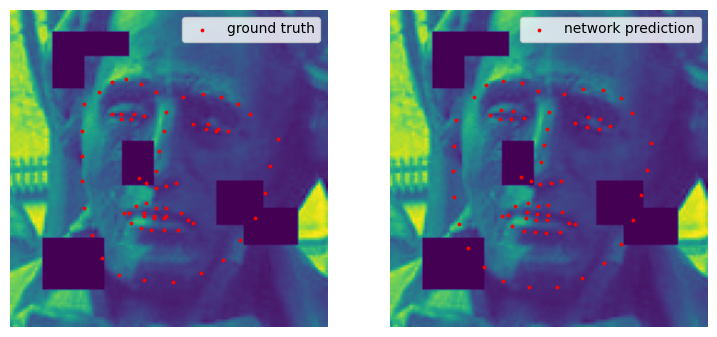

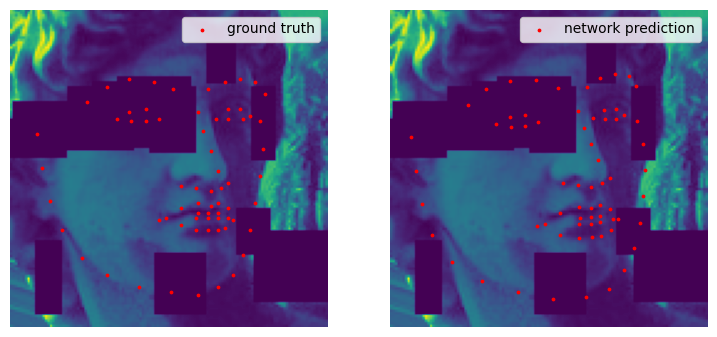

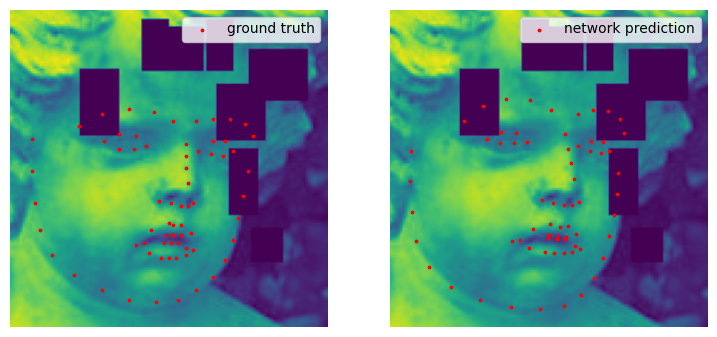

In [67]:
test_landmarks_predictor(False, 'test', train_loader, save=False)

## Train model from scratch using dataset

In [58]:
network = Network()
network.to(device)
train_masks_number = 2
torch.autograd.set_detect_anomaly(True)
train_id = datetime.datetime.now().strftime('resnet50_landmarkdetector_%Y-%m-%d_%H:%M:%S')
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

epoch_array      = []
train_loss_array = []
valid_loss_array = []

loss_min = np.inf
epoch = 0

start_time = time.time()
logfile_path = f'/content/drive/MyDrive/Postgrado/Generated/resnet50_landmarkdetector/{train_id}.log'

In [59]:
folder_path = f'/content/drive/MyDrive/Postgrado/Generated/resnet50_landmarkdetector'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Valid Steps: 1/8  Loss: 15.1920 
Valid Steps: 2/8  Loss: 16.7828 
Valid Steps: 3/8  Loss: 21.6115 
Valid Steps: 4/8  Loss: 19.6030 
Valid Steps: 5/8  Loss: 22.9540 
Valid Steps: 6/8  Loss: 22.9348 
Valid Steps: 7/8  Loss: 24.2952 
Valid Steps: 8/8  Loss: 23.0437 
--------------------------------------------------
Epoch: 52  Train Loss: 4.3132  Valid Loss: 23.0437
--------------------------------------------------
Valid Steps: 1/8  Loss: 12.7175 
Valid Steps: 2/8  Loss: 15.0267 
Valid Steps: 3/8  Loss: 14.7646 
Valid Steps: 4/8  Loss: 15.8189 
Valid Steps: 5/8  Loss: 15.4925 
Valid Steps: 6/8  Loss: 16.3230 
Valid Steps: 7/8  Loss: 16.2551 
Valid Steps: 8/8  Loss: 16.2731 
--------------------------------------------------
Epoch: 53  Train Loss: 4.3963  Valid Loss: 16.2731
--------------------------------------------------
Minimum Validation Loss of 16.2731 at epoch 53/52
Model Saved

Training Complete
Total Elapsed Time : 1036.3511822223663 s


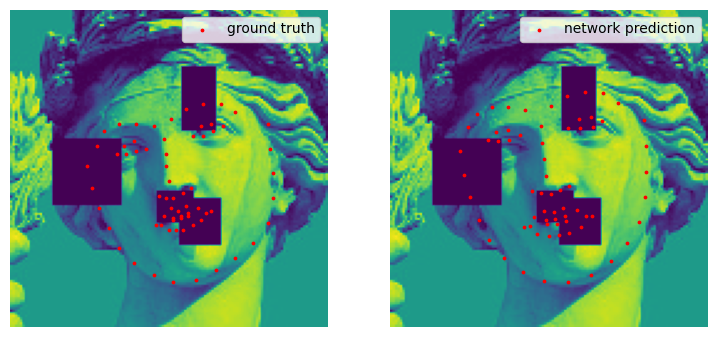

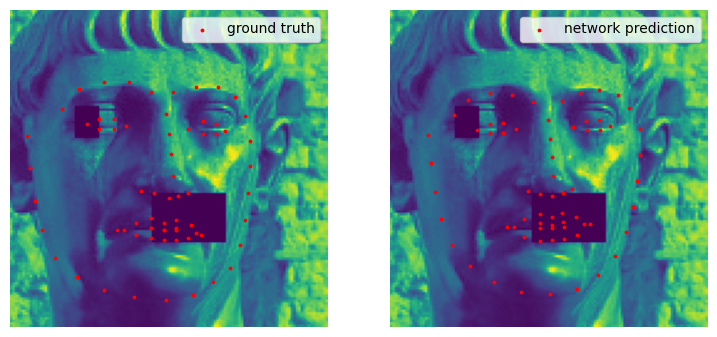

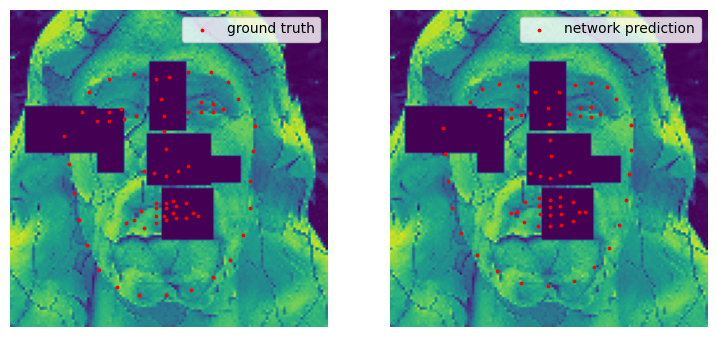

In [68]:
num_epochs = 52
while epoch <= num_epochs:
    epoch += 1
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    training_masks_number = random.randint(1, 3) * 4
    network.train()
    train_loader.dataset.set_masks_number(training_masks_number)
    test_loader.dataset.set_masks_number(training_masks_number)
    for step in range(1,len(train_loader)+1):


        images, landmarks = next(iter(train_loader))
        images = images
        landmarks = landmarks.view(landmarks.size(0),-1)

        predictions = network(images)

        # clear all the gradients before calculating them
        optimizer.zero_grad()

        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)

        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        #log_info(logfile_path, "Train Steps: %d/%d  Loss: %.4f \n" % (step, len(train_loader), running_loss))
    network.eval()
    with torch.no_grad():

        for step in range(1,len(test_loader)+1):

            images, landmarks = next(iter(test_loader))

            images = images
            landmarks = landmarks.view(landmarks.size(0),-1)

            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step
            log_info(logfile_path, "Valid Steps: %d/%d  Loss: %.4f \n" % (step, len(test_loader), running_loss))

    loss_train /= len(train_loader)
    loss_valid /= len(test_loader)

    log_info(logfile_path, '--------------------------------------------------\n')
    log_info(logfile_path, 'Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}\n'.format(epoch, loss_train, loss_valid))
    log_info(logfile_path, '--------------------------------------------------\n')
    if epoch % 4 == 0:
        test_landmarks_predictor(False, 'test', test_loader, save=True)
    epoch_array.append(epoch)
    train_loss_array.append(loss_train)
    valid_loss_array.append(loss_valid)

    if loss_valid < loss_min:
        loss_min = loss_valid
        mark_id = ''
        torch.save(network.state_dict(), f'/content/drive/MyDrive/Postgrado/Generated/resnet50_landmarkdetector/{train_id}.pth')
        log_info(logfile_path, "Minimum Validation Loss of {:.4f} at epoch {}/{}\n".format(loss_min, epoch, num_epochs))
        log_info(logfile_path, 'Model Saved\n\n')

log_info(logfile_path, 'Training Complete\n')
log_info(logfile_path, "Total Elapsed Time : {} s\n".format(time.time()-start_time))

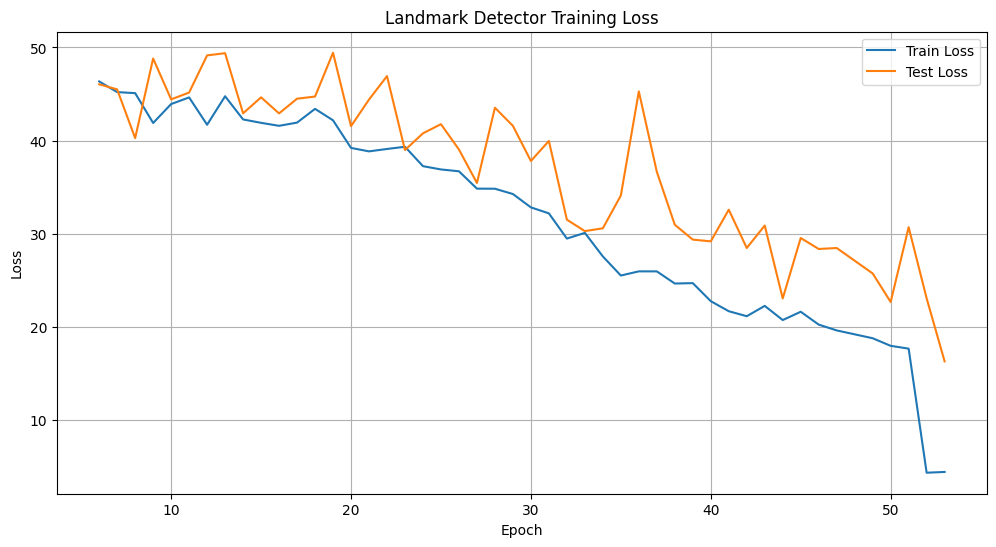

In [69]:
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(epoch_array[5:], train_loss_array[5:], label='Train Loss')
plt.plot(epoch_array[5:], valid_loss_array[5:], label='Test Loss')
plt.legend(loc="upper right")
plt.title('Landmark Detector Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
with open("/content/drive/MyDrive/Postgrado/Generated/resnet50_landmarkdetector/resnet50_landmarkdetector_2023-05-03_15:18:51.log") as fp:
    lines = fp.readlines()

for line in lines:
    if line.startswith("Epoch:"):
        epoch = int(line.split("Train Loss")[0].replace("Epoch:", "").strip())

        train_loss = line.split("Train Loss")[1].split("Valid Loss")[0].replace(":", "").strip()
        valid_loss = line.split("Valid Loss: ")[1].strip()

        print(f"{epoch:03d} & {train_loss} & {valid_loss} \\\ ")